In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [2]:
data = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import plot_tree


In [4]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


# Data Loading and Overview

In [5]:
df_1 = data.copy()

print("Shape of the DataFrame:", df_1.shape)

print("\nData Types:\n", df_1.info())

print("\nDescriptive Statistics:\n", df_1.describe())

print("\nMissing Values:\n", df_1.isnull().sum())



Shape of the DataFrame: (768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Data Types:
 None

Descriptive Statistics:
        Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      

#  Exploratory Data Analysis (EDA)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

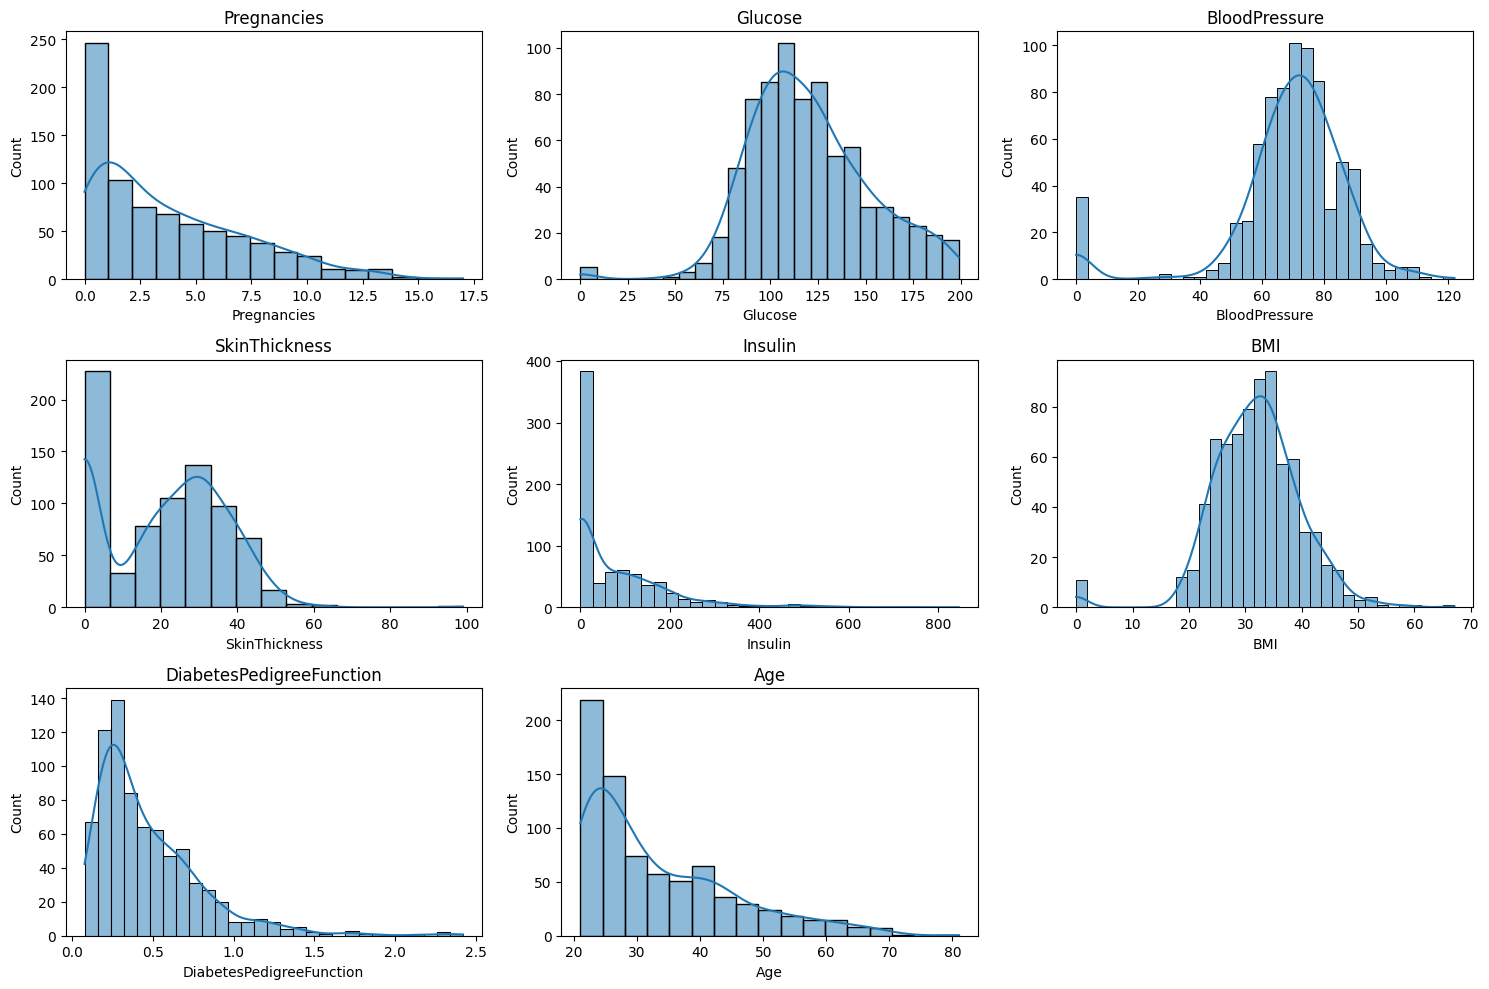

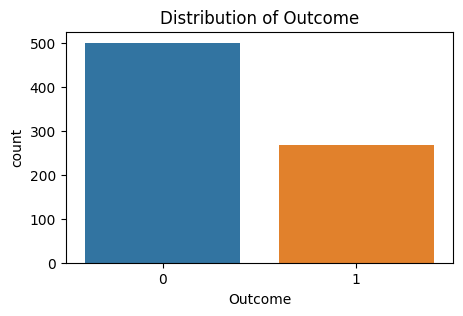

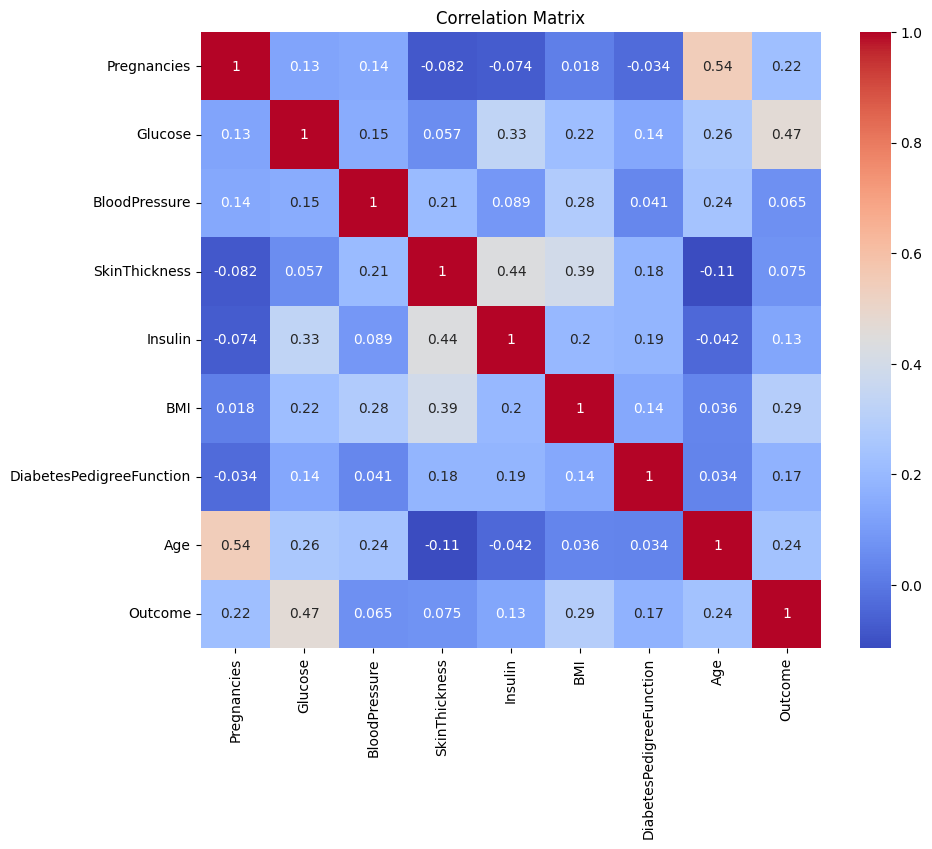

In [6]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(df_1.columns[:-1]):  # Exclude 'Outcome'
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_1[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 3))
sns.countplot(x='Outcome', data=df_1)
plt.title('Distribution of Outcome')
plt.show()


plt.figure(figsize=(10, 8))
correlation_matrix = df_1.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Data Preprocessing

Handling Missing or Invalid Values

Several medical features contain zero values which are not physiologically meaningful. These include Glucose, BloodPressure, SkinThickness, Insulin, and BMI. We replaced these invalid zeros with NaN, and imputed them using the median of each column.

In [7]:
columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in columns_to_impute:
    median_value = df_1[df_1[col] != 0][col].median()
    df_1.loc[df_1[col] == 0, col] = median_value
summary_stats = df_1.describe().T

summary_stats['skewness'] = df_1.skew()
summary_stats['kurtosis'] = df_1.kurtosis()

summary_stats


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00,0.901674,0.159220
Glucose,768.0,121.656250,30.438286,44.000,99.75000,117.0000,140.25000,199.00,0.535587,-0.257847
BloodPressure,768.0,72.386719,12.096642,24.000,64.00000,72.0000,80.00000,122.00,0.141885,1.098239
SkinThickness,768.0,29.108073,8.791221,7.000,25.00000,29.0000,32.00000,99.00,0.837608,5.430987
Insulin,768.0,140.671875,86.383060,14.000,121.50000,125.0000,127.25000,846.00,3.380019,16.232455
BMI,768.0,32.455208,6.875177,18.200,27.50000,32.3000,36.60000,67.10,0.599233,0.920222
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42,1.919911,5.594954
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00,1.129597,0.643159
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00,0.635017,-1.600930


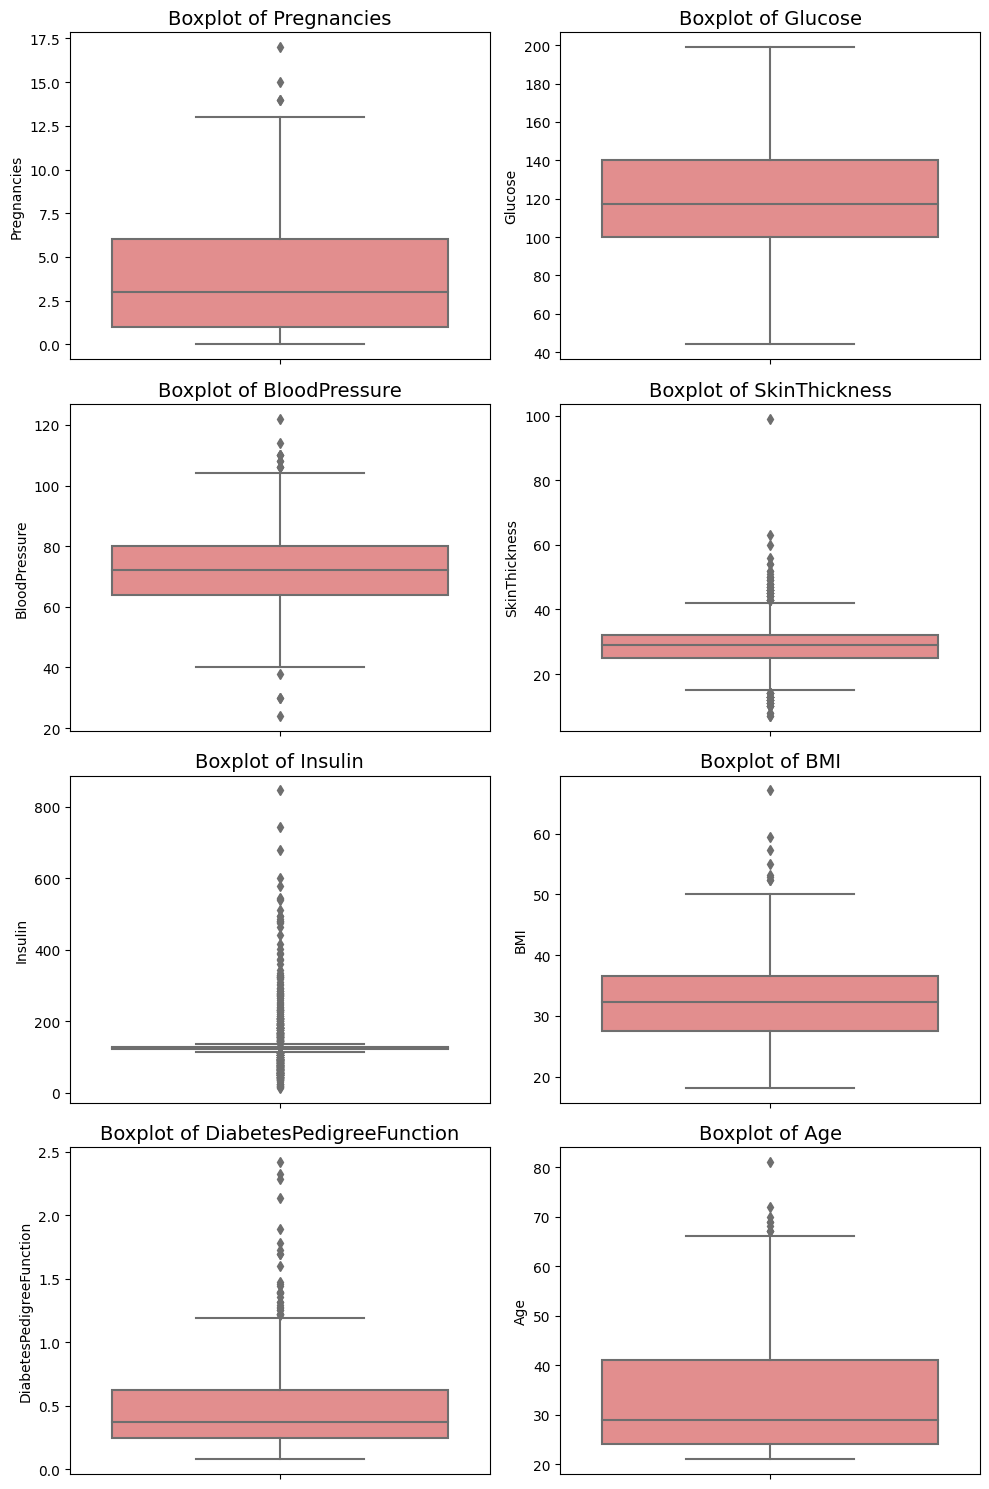

In [8]:

numerical_cols = ['Pregnancies', 'Glucose', 'BloodPressure',
                  'SkinThickness', 'Insulin', 'BMI',
                  'DiabetesPedigreeFunction', 'Age']
plt.figure(figsize=(10, 15))

for idx, col in enumerate(numerical_cols):
    plt.subplot(4, 2, idx+1)
    sns.boxplot(data=df_1, y=col, color='lightcoral')
    plt.title(f'Boxplot of {col}', fontsize=14)
    plt.ylabel(col)

plt.tight_layout()
plt.show()


In [9]:
def detect_outliers(df, features):
    outlier_info = []

    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]

        outlier_info.append({
            'Feature': feature,
            'Outlier Count': len(outliers),
            'Outlier Percentage': 100 * len(outliers) / len(df),
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound
        })

    return pd.DataFrame(outlier_info)

features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

outlier_summary = detect_outliers(df_1, features)
outlier_flags = pd.DataFrame()
for col in df_1.columns[:-1]:  # بجز Outcome
    Q1 = df_1[col].quantile(0.25)
    Q3 = df_1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_flags[col + '_outlier'] = ((df_1[col] < lower) | (df_1[col] > upper))

outlier_flags['Total_Outliers'] = outlier_flags.sum(axis=1)

df_with_flags = pd.concat([df_1, outlier_flags], axis=1)

df_with_flags[df_with_flags['Total_Outliers'] > 2].sort_values(by='Total_Outliers', ascending=False).head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_outlier,Glucose_outlier,BloodPressure_outlier,SkinThickness_outlier,Insulin_outlier,BMI_outlier,DiabetesPedigreeFunction_outlier,Age_outlier,Total_Outliers
445,0,180,78,63,14,59.4,2.420,25,1,False,False,False,True,True,True,True,False,4
39,4,111,72,47,207,37.1,1.390,56,1,False,False,False,True,True,False,True,False,3
120,0,162,76,56,100,53.2,0.759,25,1,False,False,False,True,True,True,False,False,3
125,1,88,30,42,99,55.0,0.496,26,1,False,False,True,False,True,True,False,False,3
177,0,129,110,46,130,67.1,0.319,26,1,False,False,True,True,False,True,False,False,3
370,3,173,82,48,465,38.4,2.137,25,1,False,False,False,True,True,False,True,False,3
662,8,167,106,46,231,37.6,0.165,43,1,False,False,True,True,True,False,False,False,3


In [10]:
numeric_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

group_0 = df_1[df_1['Outcome'] == 0]
group_1 = df_1[df_1['Outcome'] == 1]

results = []

for feature in numeric_features:
    stat, p_value = mannwhitneyu(group_0[feature], group_1[feature], alternative='two-sided')
    results.append({
        'Feature': feature,
        'Group 0 Mean': round(group_0[feature].mean(), 2),
        'Group 1 Mean': round(group_1[feature].mean(), 2),
        'P-Value': p_value,
        'Significant': p_value < 0.05
    })

results_df = pd.DataFrame(results)
print(results_df)

                    Feature  Group 0 Mean  Group 1 Mean       P-Value  \
0               Pregnancies          3.30          4.87  3.745146e-08   
1                   Glucose        110.68        142.13  1.507935e-40   
2             BloodPressure         70.92         75.12  2.234250e-06   
3             SkinThickness         27.73         31.69  2.319944e-09   
4                   Insulin        127.79        164.70  2.960781e-14   
5                       BMI         30.89         35.38  1.844113e-17   
6  DiabetesPedigreeFunction          0.43          0.55  1.196583e-06   
7                       Age         31.19         37.07  1.142200e-17   

   Significant  
0         True  
1         True  
2         True  
3         True  
4         True  
5         True  
6         True  
7         True  


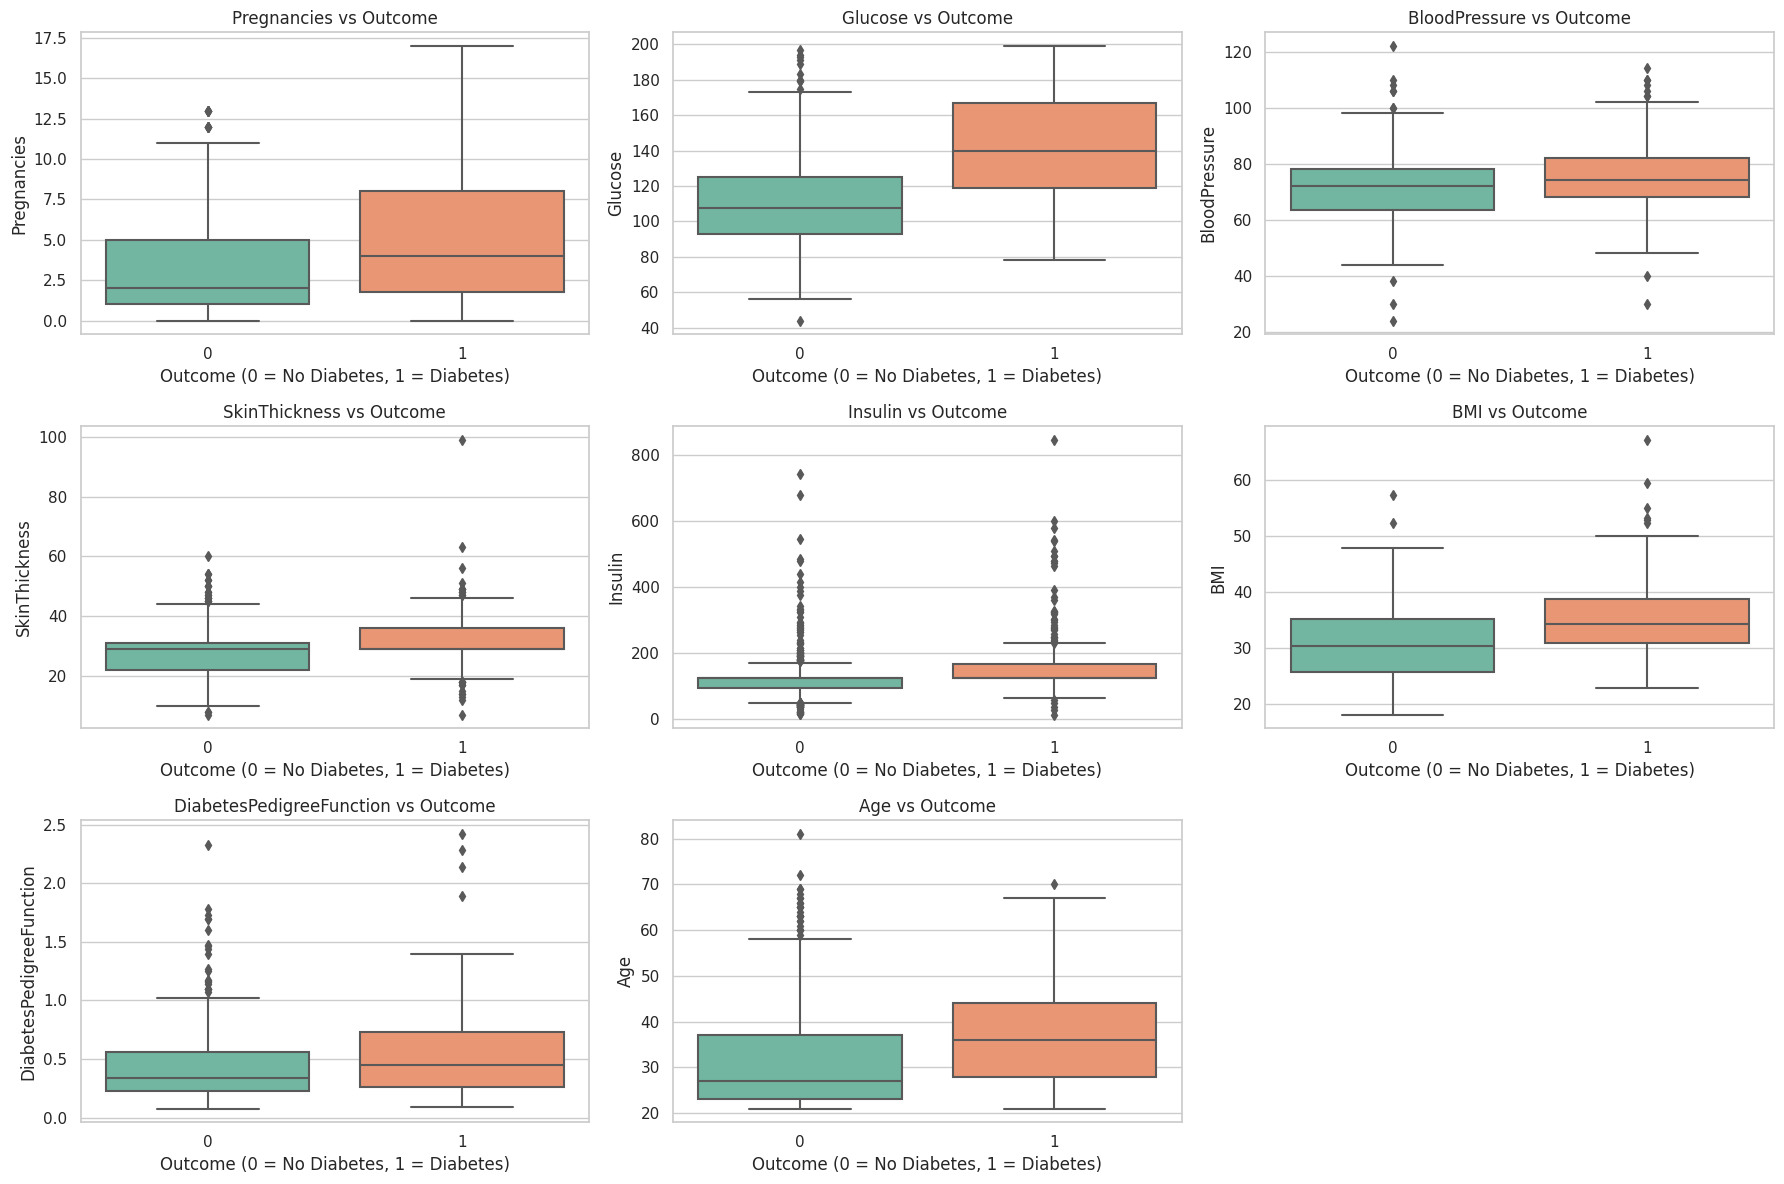

In [11]:
sns.set(style='whitegrid')
plt.figure(figsize=(18, 12))

for i, feature in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=df_1, x='Outcome', y=feature, palette='Set2')
    plt.title(f'{feature} vs Outcome')
    plt.xlabel('Outcome (0 = No Diabetes, 1 = Diabetes)')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

### Feature Engineering 

To improve model performance and help capture complex patterns, we created several interaction and ratio-based features. These include:

Glucose_Age_Interaction: captures how glucose level changes with age.

Pregnancy_Age_Ratio: normalizes the number of pregnancies by age.

BMI_Skin_Index: combines BMI and skin thickness.

Glucose_BMI_Ratio: represents the relative weight of glucose versus body mass.

In [12]:
df = data.copy()
columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in columns_to_impute:
    median_value = df[df[col] != 0][col].median()
    df.loc[df[col] == 0, col] = median_value
summary_stats = df.describe().T

df['Pregnancy_Age_Ratio'] = df['Pregnancies'] / (df['Age'] + 1)

df['Glucose_Age_Interaction'] = df['Glucose'] * df['Age']

df['BMI_Skin_Index'] = df['BMI'] * df['SkinThickness']

df['Glucose_BMI_Ratio'] = df['Glucose'] / (df['BMI'] + 1)

df['Preg_BMI_Interaction'] = df['Pregnancies'] * df['BMI']

df['Age_Glucose_BP_Combo'] = (df['Age'] * df['Glucose']) / (df['BloodPressure'] + 1)

### Baseline Modeling with Original Features

In [13]:
X = df_1.drop('Outcome', axis=1)
y = df_1['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression()
rf = RandomForestClassifier(random_state=42)

logreg.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)

for model, name in zip([logreg, rf], ['Logistic Regression', 'Random Forest']):
    print(f"\n{name}")
    y_pred = model.predict(X_test_scaled)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1]))



Logistic Regression
[[82 17]
 [21 34]]
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        99
           1       0.67      0.62      0.64        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154

ROC AUC Score: 0.82277318640955

Random Forest
[[78 21]
 [20 35]]
              precision    recall  f1-score   support

           0       0.80      0.79      0.79        99
           1       0.62      0.64      0.63        55

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154

ROC AUC Score: 0.8340679522497704


In [14]:
from xgboost import XGBClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier())
])

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

scores = cross_val_score(xgb_pipeline, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", scores)
print("Average Accuracy:", scores.mean())

y_pred = cross_val_predict(xgb_pipeline, X, y, cv=5)
print("\nClassification Report:\n", classification_report(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))

roc_auc = roc_auc_score(y, y_pred)
print("ROC AUC Score:", roc_auc)

Cross-Validation Accuracy Scores: [0.74025974 0.71428571 0.74025974 0.77777778 0.73856209]
Average Accuracy: 0.7422290128172481

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.81       500
           1       0.64      0.60      0.62       268

    accuracy                           0.74       768
   macro avg       0.72      0.71      0.71       768
weighted avg       0.74      0.74      0.74       768

Confusion Matrix:
 [[409  91]
 [107 161]]
ROC AUC Score: 0.7093731343283582


In [15]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
])

svm_pipeline.fit(X_train, y_train)

y_pred = svm_pipeline.predict(X_test)
y_proba = svm_pipeline.predict_proba(X_test)[:, 1]

print("=== SVM RBF ===")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

=== SVM RBF ===
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81        99
           1       0.67      0.58      0.62        55

    accuracy                           0.75       154
   macro avg       0.72      0.71      0.72       154
weighted avg       0.74      0.75      0.74       154

Confusion Matrix:
 [[83 16]
 [23 32]]
ROC AUC Score: 0.8086317722681359


In [16]:
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)
y_proba = lgbm.predict_proba(X_test)[:, 1]

print("=== LightGBM ===")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

[LightGBM] [Info] Number of positive: 213, number of negative: 401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346906 -> initscore=-0.632669
[LightGBM] [Info] Start training from score -0.632669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [17]:
cat = CatBoostClassifier(verbose=0, random_state=42)
cat.fit(X_train, y_train)

y_pred = cat.predict(X_test)
y_proba = cat.predict_proba(X_test)[:, 1]

print("=== CatBoost ===")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

=== CatBoost ===
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        99
           1       0.67      0.71      0.69        55

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.76       154
weighted avg       0.78      0.77      0.77       154

Confusion Matrix:
[[80 19]
 [16 39]]
ROC AUC Score: 0.8202020202020202


| مدل           | Accuracy | Recall (1) | F1 (1)  | ROC AUC    |
| ------------- | -------- | ---------- | ------- | ---------- |
| Logistic Reg. | 75%      | 62%        | 64%     | 0.82       |
| Random Forest | 73%      | 64%        | 63%     | 0.83 ✅     |
| SVM (RBF)     | 75%      | 58%        | 62%     | 0.81       |
| LightGBM      | 72%      | 65%        | 63%     | 0.79       |
| **CatBoost**  | **77%**  | **71%**    | **69%** | **0.82** ✅ |


# Modeling with Original + Engineered Features

In [18]:
X = df.drop(columns='Outcome')
y = df['Outcome']

X_log = X.copy()
cols_to_log = ['Insulin', 'BMI', 'SkinThickness', 'Glucose']
for col in cols_to_log:
    X_log[col] = X_log[col].apply(lambda x: np.log1p(x))  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression()
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}]
}
f1_scorer = make_scorer(f1_score)

grid = GridSearchCV(model, param_grid, scoring=f1_scorer, cv=5)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("=== Logistic Regression with Optimized Weights ===")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))
print("Best Params:", grid.best_params_)

conf = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf.ravel()
print(f"False Positives (FP): {fp}, False Negatives (FN): {fn}")

cv_scores = cross_val_score(best_model, X_scaled, y, cv=5, scoring='f1')
print("Cross-Validation F1 scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

=== Logistic Regression with Optimized Weights ===
              precision    recall  f1-score   support

           0       0.90      0.62      0.73       100
           1       0.55      0.87      0.68        54

    accuracy                           0.71       154
   macro avg       0.73      0.75      0.70       154
weighted avg       0.78      0.71      0.71       154

Confusion Matrix:
 [[62 38]
 [ 7 47]]
ROC AUC: 0.8098148148148148
Best Params: {'C': 0.01, 'class_weight': {0: 1, 1: 3}}
False Positives (FP): 38, False Negatives (FN): 7
Cross-Validation F1 scores: [0.62318841 0.64285714 0.70149254 0.71111111 0.68085106]
Mean F1 Score: 0.6719000521817151


In [19]:
X_log = X.copy()
for col in ['Insulin', 'BMI', 'SkinThickness', 'Glucose']:
    X_log[col] = X_log[col].apply(lambda x: np.log1p(x))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

svm = SVC(probability=True)
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'class_weight': [None, 'balanced']
}
grid_svm = GridSearchCV(svm, param_grid, scoring='f1', cv=5)
grid_svm.fit(X_train, y_train)

best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)

print("=== Optimized SVM ===")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("ROC AUC:", roc_auc_score(y_test, best_svm.predict_proba(X_test)[:, 1]))
print("Best Params:", grid_svm.best_params_)

conf = confusion_matrix(y_test, y_pred_svm)
tn, fp, fn, tp = conf.ravel()
print(f"False Positives (FP): {fp}, False Negatives (FN): {fn}")

cv_scores = cross_val_score(best_svm, X_scaled, y, cv=5, scoring='f1')
print("Cross-Validation F1 scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

=== Optimized SVM ===
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       100
           1       0.62      0.80      0.70        54

    accuracy                           0.76       154
   macro avg       0.75      0.77      0.75       154
weighted avg       0.78      0.76      0.76       154

Confusion Matrix:
 [[74 26]
 [11 43]]
ROC AUC: 0.805
Best Params: {'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf'}
False Positives (FP): 26, False Negatives (FN): 11
Cross-Validation F1 scores: [0.66666667 0.6984127  0.69421488 0.74137931 0.71428571]
Mean F1 Score: 0.7029918531485929


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_knn = GridSearchCV(knn, param_grid, scoring='f1', cv=5)
grid_knn.fit(X_train, y_train)

best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

print("=== Optimized KNN ===")
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("ROC AUC:", roc_auc_score(y_test, best_knn.predict_proba(X_test)[:, 1]))
print("Best Params:", grid_knn.best_params_)

conf = confusion_matrix(y_test, y_pred_knn)
tn, fp, fn, tp = conf.ravel()
print(f"False Positives (FP): {fp}, False Negatives (FN): {fn}")

cv_scores = cross_val_score(best_knn, X_scaled, y, cv=5, scoring='f1')
print("Cross-Validation F1 scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

=== Optimized KNN ===
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       100
           1       0.62      0.52      0.57        54

    accuracy                           0.72       154
   macro avg       0.69      0.67      0.68       154
weighted avg       0.71      0.72      0.71       154

Confusion Matrix:
 [[83 17]
 [26 28]]
ROC AUC: 0.8075
Best Params: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
False Positives (FP): 17, False Negatives (FN): 26
Cross-Validation F1 scores: [0.60952381 0.64864865 0.52272727 0.68686869 0.62745098]
Mean F1 Score: 0.6190438796321149


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

rfc = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'class_weight': [None, 'balanced']
}
grid_rfc = GridSearchCV(rfc, param_grid, scoring='f1', cv=5)
grid_rfc.fit(X_train, y_train)

best_rfc = grid_rfc.best_estimator_
y_pred_rfc = best_rfc.predict(X_test)

print("=== Optimized Random Forest ===")
print(classification_report(y_test, y_pred_rfc))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rfc))
print("ROC AUC:", roc_auc_score(y_test, best_rfc.predict_proba(X_test)[:, 1]))
print("Best Params:", grid_rfc.best_params_)

conf = confusion_matrix(y_test, y_pred_rfc)
tn, fp, fn, tp = conf.ravel()
print(f"False Positives (FP): {fp}, False Negatives (FN): {fn}")

cv_scores = cross_val_score(best_rfc, X_scaled, y, cv=5, scoring='f1')
print("Cross-Validation F1 scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

=== Optimized Random Forest ===
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       100
           1       0.61      0.78      0.68        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.74       154
weighted avg       0.77      0.75      0.75       154

Confusion Matrix:
 [[73 27]
 [12 42]]
ROC AUC: 0.8244444444444443
Best Params: {'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 200}
False Positives (FP): 27, False Negatives (FN): 12
Cross-Validation F1 scores: [0.67741935 0.64       0.73873874 0.76521739 0.68376068]
Mean F1 Score: 0.701027233728496


In [22]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [100, 200, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128]
}

cat_model = CatBoostClassifier(verbose=0, random_state=42)

random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=30, 
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best ROC AUC Score:", random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'learning_rate': 0.01, 'l2_leaf_reg': 9, 'iterations': 200, 'depth': 8, 'border_count': 128}
Best ROC AUC Score: 0.8453362761986792


In [23]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model = CatBoostClassifier(
    learning_rate=0.01,
    l2_leaf_reg=9,
    iterations=200,
    depth=8,
    border_count=128,
    verbose=0,
    random_state=42
)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

conf = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf.ravel()
print(f"False Positives (FP): {fp}, False Negatives (FN): {fn}")

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='f1')
print("Cross-Validation F1 scores:", cv_scores)
print("Mean F1 Score:", np.mean(cv_scores))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.80        99
           1       0.64      0.69      0.67        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.74       154
weighted avg       0.76      0.75      0.76       154

Confusion Matrix:
 [[78 21]
 [17 38]]
ROC AUC Score: 0.8269972451790634
False Positives (FP): 21, False Negatives (FN): 17
Cross-Validation F1 scores: [0.62135922 0.6        0.59340659 0.73267327 0.58947368]
Mean F1 Score: 0.6273825536489646


# False Positives and False Negatives Analysis
### FP/FN Error Pattern Analysis

To further improve the model, I extracted the False Positives (FP) and False Negatives (FN) from the confusion matrix and analyzed them separately.

I trained a decision tree classifier on these misclassified samples to discover hidden patterns. For example, many false positives were younger individuals with very high glucose, and false negatives often had borderline values in glucose and BMI.

This analysis inspired the creation of new derived features that aimed to capture these patterns.


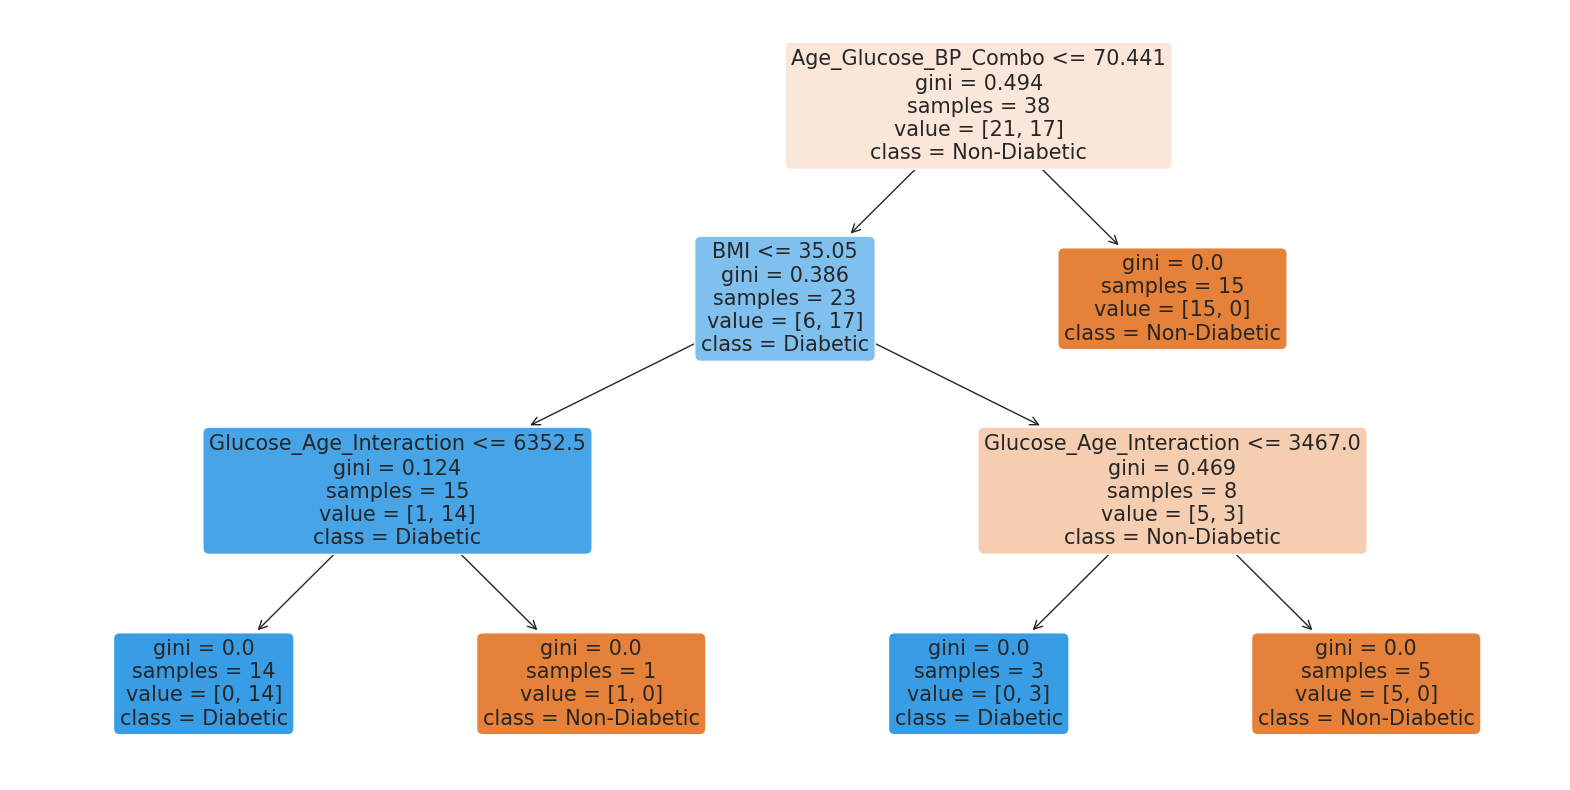

In [24]:
y_pred = best_model.predict(X_test)

results = X_test.copy()
results['True_Label'] = y_test.values
results['Predicted_Label'] = y_pred

misclassified = results[results['True_Label'] != results['Predicted_Label']]

false_positives = results[(results['True_Label'] == 0) & (results['Predicted_Label'] == 1)]

false_negatives = results[(results['True_Label'] == 1) & (results['Predicted_Label'] == 0)]

error_data = pd.concat([false_negatives, false_positives])
error_data['True_Label'] = error_data['True_Label'].astype(int)

X_error = error_data.drop(columns=['True_Label', 'Predicted_Label'])
y_error = error_data['True_Label']

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_error, y_error)

plt.figure(figsize=(20, 10))
plot_tree(clf,
          feature_names=X_error.columns,
          class_names=['Non-Diabetic', 'Diabetic'],
          filled=True, rounded=True)
plt.show()


### Using Error Pattern as a Feature

The decision tree trained on FP and FN instances was used to derive a new binary feature for the entire dataset. This feature represents whether a sample matches the learned misclassification pattern.

Incorporating this feature into the final model helped reduce misclassifications, especially in borderline cases.




In [25]:
error_pattern_score = clf.predict_proba(X)[:, 1] 
X["error_pattern_score"] = error_pattern_score


### Final Model Selection & Hyperparameter Tuning

After comparing multiple models, I selected `CatBoostClassifier` as the final model due to its superior performance and handling of non-linear relationships and feature interactions.

I performed hyperparameter tuning using `GridSearchCV` and evaluated the optimized model using cross-validation.


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

best_model = CatBoostClassifier(
    learning_rate=0.01,
    l2_leaf_reg=9,
    iterations=200,
    depth=8,
    class_weights=  [1, 3],
    border_count=128,
    verbose=0,
    random_state=42
)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.66      0.76       100
           1       0.58      0.87      0.70        54

    accuracy                           0.73       154
   macro avg       0.74      0.77      0.73       154
weighted avg       0.79      0.73      0.74       154

Confusion Matrix:
 [[66 34]
 [ 7 47]]
ROC AUC Score: 0.8244444444444444


### Class Weight Optimization

To handle class imbalance and minimize false negatives (which are critical in medical prediction tasks), I performed manual and automated class weight optimization.

The final class weights significantly improved recall for the positive class without sacrificing much precision, leading to a better-balanced model.


In [27]:
weights = [1.0, 1.2, 2, 2.1, 2.2, 2.3, 2.4, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 3.2, 3.3, 3.4, 3.5,3.6, 3.7, 3.8, 3.9, 4, 4.1, 4.2, 5, 6 ,7]
for w in weights:
    model = CatBoostClassifier(
    learning_rate=0.01,
    l2_leaf_reg=9,
    iterations=200,
    depth=8,
    class_weights=  [1, w],
    border_count=128,
    verbose=0,
    random_state=42
)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f"Weight 1:{w} → F1 Score: {f1:.4f}")

Weight 1:1.0 → F1 Score: 0.5859
Weight 1:1.2 → F1 Score: 0.6126
Weight 1:2 → F1 Score: 0.6667
Weight 1:2.1 → F1 Score: 0.6667
Weight 1:2.2 → F1 Score: 0.6667
Weight 1:2.3 → F1 Score: 0.6614
Weight 1:2.4 → F1 Score: 0.6875
Weight 1:2.4 → F1 Score: 0.6875
Weight 1:2.5 → F1 Score: 0.6977
Weight 1:2.6 → F1 Score: 0.7023
Weight 1:2.7 → F1 Score: 0.7121
Weight 1:2.8 → F1 Score: 0.7121
Weight 1:2.9 → F1 Score: 0.7068
Weight 1:3 → F1 Score: 0.6963
Weight 1:3.1 → F1 Score: 0.7059
Weight 1:3.2 → F1 Score: 0.7007
Weight 1:3.3 → F1 Score: 0.7111
Weight 1:3.4 → F1 Score: 0.6957
Weight 1:3.5 → F1 Score: 0.6957
Weight 1:3.6 → F1 Score: 0.6906
Weight 1:3.7 → F1 Score: 0.6812
Weight 1:3.8 → F1 Score: 0.6906
Weight 1:3.9 → F1 Score: 0.6906
Weight 1:4 → F1 Score: 0.6906
Weight 1:4.1 → F1 Score: 0.7000
Weight 1:4.2 → F1 Score: 0.7092
Weight 1:5 → F1 Score: 0.6944
Weight 1:6 → F1 Score: 0.6667
Weight 1:7 → F1 Score: 0.6579


In [28]:
best_model = CatBoostClassifier(
    learning_rate=0.01,
    l2_leaf_reg=9,
    iterations=200,
    depth=8,
    class_weights=  [1, 2.8],
    border_count=128,
    verbose=0,
    random_state=42
)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.69      0.78       100
           1       0.60      0.87      0.71        54

    accuracy                           0.75       154
   macro avg       0.76      0.78      0.75       154
weighted avg       0.80      0.75      0.76       154

Confusion Matrix:
 [[69 31]
 [ 7 47]]
ROC AUC Score: 0.8274074074074074
